# Pairs Trading Strategy

Pairs trading is a nice example of a strategy based on mathematical analysis. 

The principle is as follows:
Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, for example Pepsi and Coca Cola. You expect the spread (ratio or difference in prices) between these two to remain constant with time. However, from time to time, there might be a divergence in the spread between these two pairs. The divergence within a pair can be caused by temporary supply/demand changes, large buy/sell orders for one security, reaction for important news about one of the companies, and so on. When there is a temporary divergence between the two securities, i.e. one stock moves up while the other moves down, the pairs trade would be to short the outperforming stock and to long the underperforming one, betting that the "spread" between the two would eventually converge.

Pairs trading is a market neutral trading strategy enabling traders to profit from virtually any market conditions: uptrend, downtrend, or sideways movement.

We'll start by constructing an artificial example.

In [16]:
!pip install statsmodels --user  
!pip install tensorboardX --user
!pip install pandas==0.24.2 --user
!pip install plotly
!pip install bs4 --user
!pip install plotly --user
!pip install -U auquan_toolbox --user

Requirement already up-to-date: auquan_toolbox in /home/james/anaconda3/lib/python3.8/site-packages (2.1.92)


In [17]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

### Explaining the Concept: We start by generating two fake securities.
We model X's daily returns by drawing from a normal distribution. Then we perform a cumulative sum to get the value of X on each day.

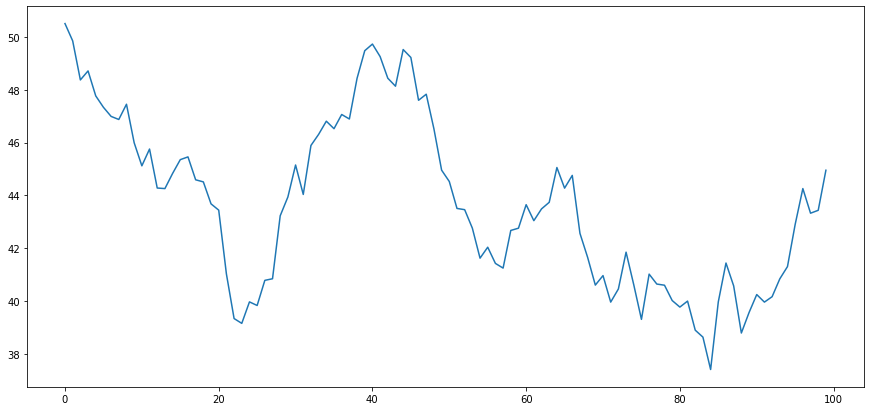

In [18]:
# Generate the daily returns
Xreturns = np.random.normal(0, 1, 100) 
# sum them and shift all the prices up
X = pd.Series(np.cumsum(Xreturns), name='X') + 50
X.plot(figsize=(15,7))
plt.show()

Now we generate Y. Y is supposed to have a deep economic link to X, so the price of Y should vary pretty similarly. We model this by taking X, shifting it up and adding some random noise drawn from a normal distribution.

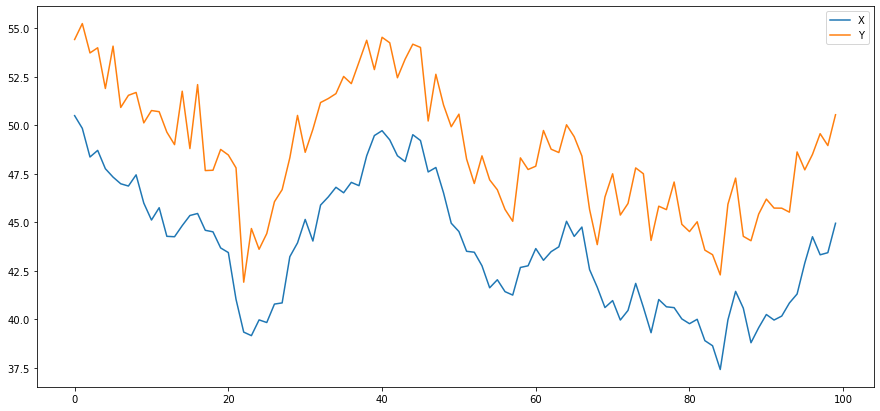

In [19]:
noise = np.random.normal(0, 1, 100)
Y = X + 5 + noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot(figsize=(15,7))
plt.show()

### Cointegration
Cointegration, very loosely speaking, is a "different" form of correlation. If two series are cointegrated, the ratio between them will vary around a mean.
For pairs trading to work between two timeseries, the expected value of the ratio over time must converge to the mean, i.e. they should be cointegrated.
The time series we constructued above are cointegrated. 

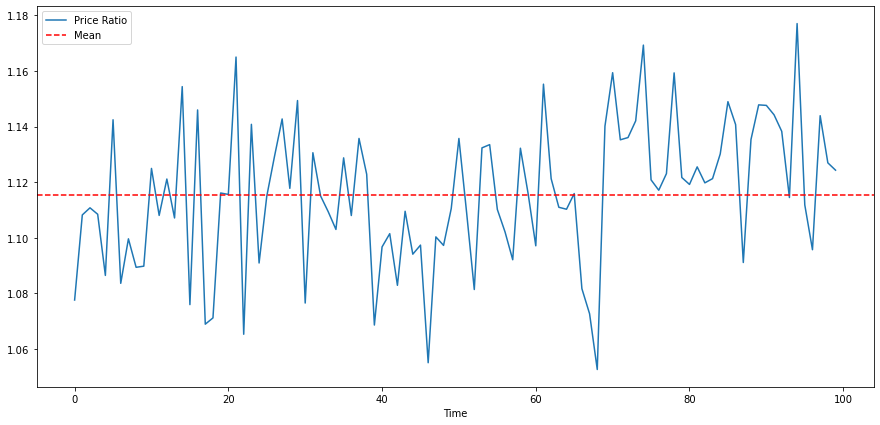

In [20]:
(Y/X).plot(figsize=(15,7)) 
plt.axhline((Y/X).mean(), color='red', linestyle='--') 
plt.xlabel('Time')
plt.legend(['Price Ratio', 'Mean'])
plt.show()

### Testing for Cointegration
There is a convenient test that lives in statsmodels.tsa.stattools. We should see a very low p-value, as we've artificially created two series that are as cointegrated as physically possible.

In [21]:
# compute the p-value of the cointegration test
# will inform us as to whether the ratio between the 2 timeseries is stationary
# around its mean
score, pvalue, _ = coint(X,Y)



### How to make a pairs trade?
Because two cointegrated time series (such as X and Y above) drift towards and apart from each other, there will be times when the spread is high and times when the spread is low. We make a pairs trade by buying one security and selling another. This way, if both securities go down together or go up together, we neither make nor lose money — we are market neutral.

Going back to X and Y above that follow Y = ⍺ X + e, such that ratio (Y/X) moves around it’s mean value ⍺, we make money on the ratio of the two reverting to the mean. In order to do this we’ll watch for when X and Y are far apart, i.e ⍺ is too high or too low:

* Going Long the Ratio This is when the ratio ⍺ is smaller than usual and we expect it to increase. In the above example, we place a bet on this by buying Y and selling X.
* Going Short the Ratio This is when the ratio ⍺ is large and we expect it to become smaller. In the above example, we place a bet on this by selling Y and buying X.

<b>Note </b> that we always have a “hedged position”: a short position makes money if the security sold loses value, and a long position will make money if a security gains value, so we’re immune to overall market movement. We only make or lose money if securities X and Y move relative to each other.

### Using Data to find securities that behave like this
The best way to do this is to start with securities you suspect may be cointegrated and perform a statistical test. If you just run statistical tests over all pairs, you’ll fall prey to multiple comparison bias.

<b>Multiple comparisons bias </b> is simply the fact that there is an increased chance to incorrectly generate a significant p-value when many tests are run, because we are running a lot of tests. If 100 tests are run on random data, we should expect to see 5 p-values below 0.05. If you are comparing n securities for co-integration, you will perform n(n-1)/2 comparisons, and you should expect to see many incorrectly significant p-values, which will increase as you increase. To avoid this, pick a small number of pairs you have reason to suspect might be cointegrated and test each individually. This will result in less exposure to multiple comparisons bias.

So let’s try to find some securities that display cointegration. Let’s work with a basket of US large cap tech stocks — in S&P 500. These stocks operate in a similar segment and could have cointegrated prices. We scan through a list of securities and test for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05. This method is prone to multiple comparison bias and in practice the securities should be subject to a second verification step. Let’s ignore this for the sake of this example.

Note: We include the market benchmark (SPY) in our data — the market drives the movement of so many securities that often you might find two seemingly cointegrated securities; but in reality they are not cointegrated with each other but both cointegrated with the market. This is known as a confounding variable and it is important to check for market involvement in any relationship you find.


In [8]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [9]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2007/12/01'
endDateStr = '2017/12/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','AAPL','ADBE','EBAY','MSFT','QCOM',
                 'HPQ','JNPR','AMD','IBM']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

ModuleNotFoundError: No module named 'tensorboardX'

In [10]:
data.head(3)

NameError: name 'data' is not defined

Lets  run our method on the list and see if any pairs are cointegrated.

In [11]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

NameError: name 'data' is not defined

Looks like 'ADBE' and 'MSFT' are cointegrated. Let's take a look at the prices to make sure there's nothing weird going on

In [12]:
S1 = data['ADBE']
S2 = data['MSFT']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

NameError: name 'data' is not defined

The ratio does look like it moved around a stable mean.The absolute ratio isn’t very useful in statistical terms. It is more helpful to normalize our signal by treating it as a z-score. Z score is defined as:

<i>Z Score (Value) = (Value — Mean) / Standard Deviation </i>

<b>WARNING</b>
In practice this is usually done to try to give some scale to the data, but this assumes an underlying distribution. Usually normal. However, much financial data is not normally distributed, and we must be very careful not to simply assume normality, or any specific distribution when generating statistics. The true distribution of ratios could be very fat-tailed and prone to extreme values messing up our model and resulting in large losses.

In [13]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [14]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

NameError: name 'ratios' is not defined

### Simple Strategy:
* Go "Long" the ratio whenever the z-score is below -1.0
* Go "Short" the ratio when the z-score is above 1.0
* Exit positions when the z-score approaches zero

This is just the tip of the iceberg, and only a very simplistic example to illustrate the concepts.
* In practice you would want to compute a more optimal weighting for how many shares to hold for S1 and S2
* You would also want to trade using constantly updating statistics. 

In general taking a statistic over your whole sample size can be bad. For example, if the market is moving up, and both securities with it, then your average price over the last 3 years may not be representative of today. For this reason traders often use statistics that rely on rolling windows of the most recent data.

Instead of using ratio values, let's use 5d Moving Average to compute to z score, and the 60d Moving Average and 60d Standard Deviation as the mean and standard deviation.

First break the data into training set of 7 years and test set of 3 years

In [15]:
ratios = data['ADBE'] / data['MSFT']
print(len(ratios))
train = ratios[:1762]
test = ratios[1762:]

2518


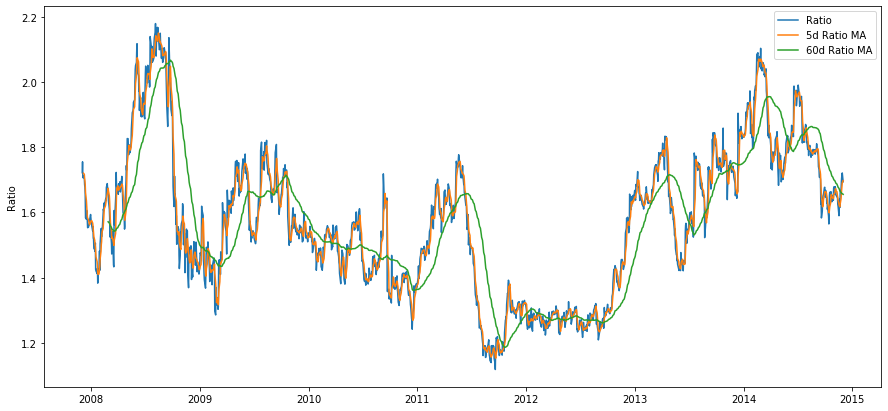

In [16]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

We can use the moving averages to compute the z-score of the ratio at each given time. This will tell us how extreme the ratio is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.


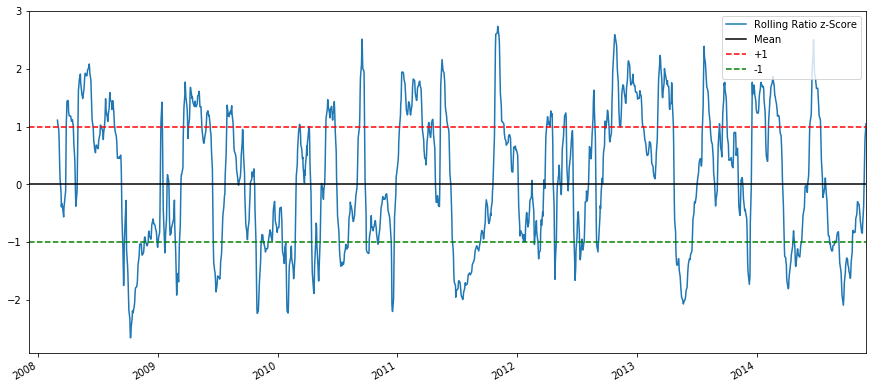

In [36]:
# Take a rolling 60 day standard deviation
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like.


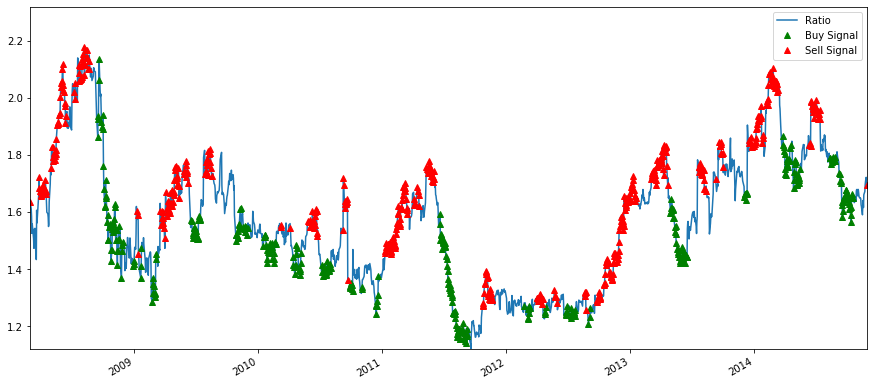

In [18]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

What does that mean for actual stocks that we are trading? Let’s take a look

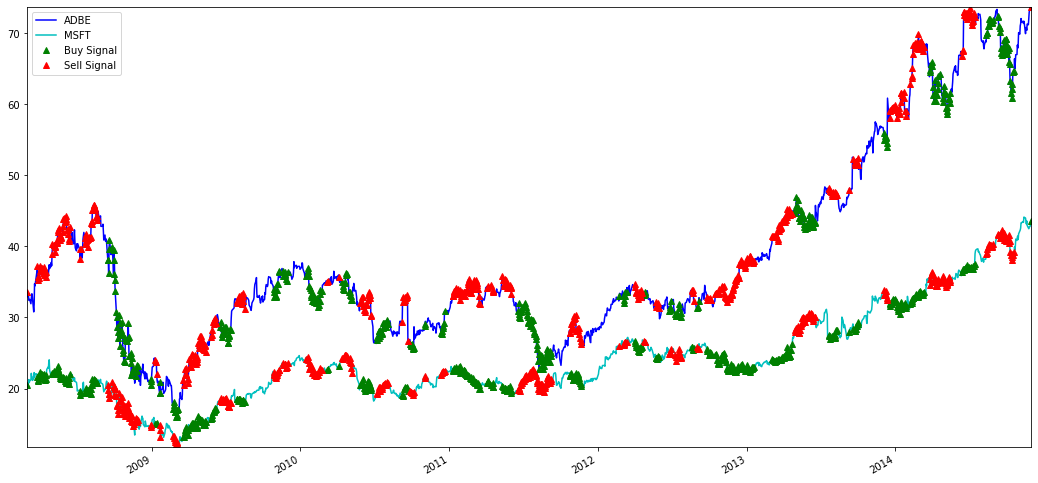

In [19]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = data['ADBE'].iloc[:1762]
S2 = data['MSFT'].iloc[:1762]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['ADBE','MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()


Notice how we sometimes make money on the short leg and sometimes on the long leg, and sometimes both.

Let’s see what kind of profits this signal can generate. We write a simple backtester which buys 1 ratio (buy 1 ADBE stock and sell ratio x MSFT stock) when ratio is low, sell 1 ratio (sell 1 ADBE stock and buy ratio x MSFT stock) when it’s high and calculate PnL of these trades.

In [58]:
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money


trade(data['ADBE'].iloc[:1762], data['MSFT'].iloc[:1762], 5, 60)


629.7085162722666

The strategy seems profitable! Now we can optimize further by changing our moving average windows, by changing the thresholds for buy/sell and exit positions etc and check for performance improvements on validation data.
We could also try more sophisticated models like Logistic Regression, SVM etc to make our 1/-1 predictions.

Let's see how it does on test data

In [59]:
trade(data['ADBE'].iloc[1762:], data['MSFT'].iloc[1762:], 5, 90)

1177.3686879906131

# Profits again!

### Avoid Overfitting

Overfitting is the most dangerous pitfall of a trading strategy. In our model, we used rolling parameter estimates and may wish to optimize window length. We can simply iterate over all possible, reasonable window lengths and pick the length based on which our model performs the best . Below we write a simple loop to score window lengths based on pnl of training data and find the best one.

In [60]:
# Find the window length 0-254 
# that gives the highest returns using this strategy
length_scores = [trade(data['ADBE'].iloc[:1762], 
                data['MSFT'].iloc[:1762], 5, l) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

Best window length: 246


Now we check the performance of our model on test data and we find that this window length is far from optimal! This is because our original choice was clearly overfitted to the sample data.

In [61]:
# Find the returns for test data
# using what we think is the best window length
length_scores2 = [trade(data['ADBE'].iloc[1762:], 
                  data['MSFT'].iloc[1762:],5, l) 
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

246 day window: 987.0064133650166
191 day window: 1572.1954993100194


We can see this if we also plot Pnl by window length separately for traning and test data

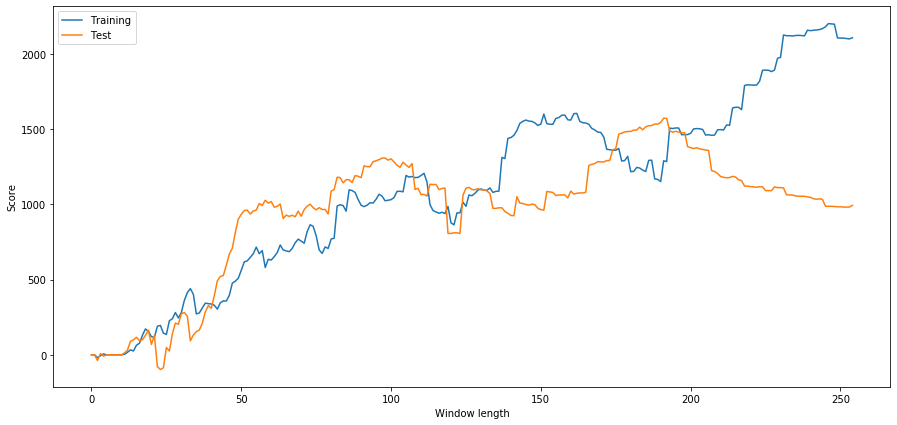

In [62]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()